In [1]:
import yaml
import sys
sys.path.append("../")
from plugins.interfaces.diagnostics import AWAFrameGrabberDiagnostic, ROI


In [2]:
# define screen and trim parameters
screen = "DYG2"
trim = "DT2"
trim_info = yaml.safe_load(open("awa_config/awa_drive_magnet_config.yml"))[trim]
screen_info = yaml.safe_load(open("awa_config/awa_drive_camera_config.yml"))[screen]

In [3]:
# create Xopt objects
from xopt import VOCS
vocs = VOCS(
    variables = {
        trim_info[name]["PV"]:trim_info[name]["RANGE"] for name in ["H","V"]
    },
    objectives = {"center_dist":"MINIMIZE"}
)

In [4]:
screen_roi = ROI(
    xcenter=int(screen_info["center"][0]),
    ycenter=int(screen_info["center"][1]),
    xwidth=int(screen_info["radius"]),
    ywidth=int(screen_info["radius"]),
)

image_diagnostic = AWAFrameGrabberDiagnostic(
    roi=screen_roi, apply_bounding_box_constraint=False, visualize=False
)

In [5]:
image_diagnostic

AWAFrameGrabberDiagnostic(screen_name='AWANIFrameGrabber', ip_address='N/A', alias=None, array_data_suffix='N/A', array_n_cols_suffix='N/A', array_n_rows_suffix='N/A', resolution_suffix=None, resolution=1.0, beam_shutter_pv=None, extra_pvs=[], background_file=None, save_image_location=None, roi=ROI(xcenter=341, ycenter=258, xwidth=200, ywidth=200), gain=1.0, min_log_intensity=4.0, bounding_box_half_width=3.0, wait_time=1.0, n_fitting_restarts=1, visualize=False, verbose=True, return_statistics=False, threshold=0.0, apply_bounding_box_constraint=False, target_charge=None, target_charge_pv=None, charge_atol=0.1, testing=False)

displaying image
fitting image


{'Cx': nan,
 'Cy': nan,
 'Sx': nan,
 'Sy': nan,
 'bb_penalty': nan,
 'total_intensity': 2729583.0,
 'log10_total_intensity': 6.436096304684827}

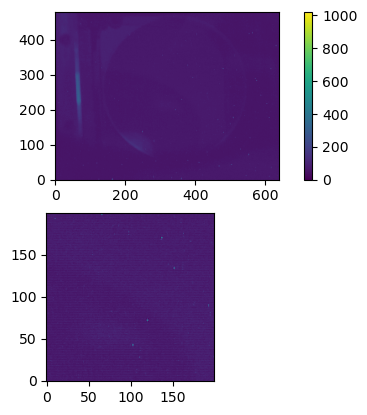

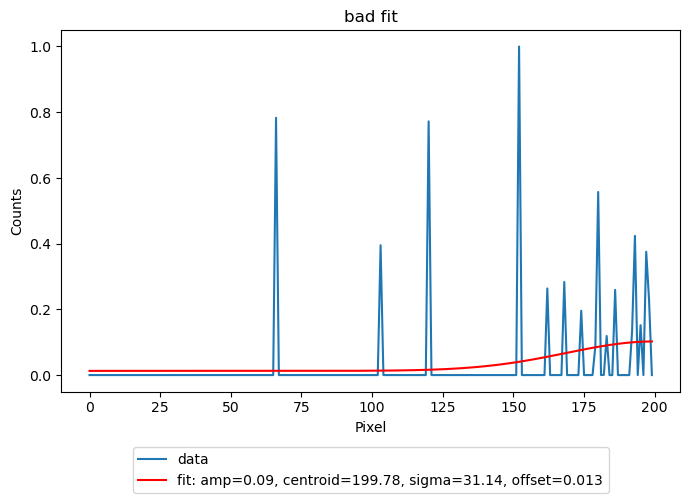

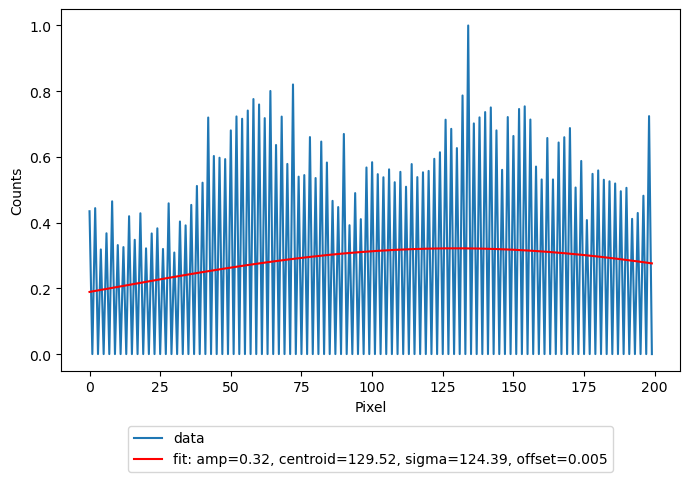

In [6]:
image_diagnostic.test_measurement()

In [7]:
import time
from xopt import Evaluator
from epics import caput

def evaluate(inputs: dict):
    global image_diagnostic
    # caput values
    for name, val in inputs.items():
        caput(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(1.0)

    results = image_diagnostic.measure_beamsize(1, **inputs)

    # measure distance to image center
    print(results["Cx"], image_diagnostic.roi.xwidth/2)
    results["center_dist_x"] = results["Cx"] - image_diagnostic.roi.xwidth/2
    results["center_dist_y"] = results["Cy"] - image_diagnostic.roi.ywidth/2

    results["center_dist"] = (results["center_dist_x"]**2 + results["center_dist_y"]**2)**0.5
    results["time"] = time.time()
    
    return results

evaluator = Evaluator(function=evaluate)

In [8]:
evaluate({})

CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:51190, Ignored: 192.168.0.2:51190"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Feb 26 2024 15:23:50.706166412
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:51190, Ignored: awa3.hep.anl.gov:51190"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Feb 26 2024 15:23:50.707265468
..................................................................


fitting image
nan 100.0


{'Cx': nan,
 'Cy': nan,
 'Sx': nan,
 'Sy': nan,
 'bb_penalty': nan,
 'total_intensity': 2321715.0,
 'log10_total_intensity': 6.365808907252723,
 'center_dist_x': nan,
 'center_dist_y': nan,
 'center_dist': nan,
 'time': 1708982632.50507}

In [9]:
from xopt.generators import get_generator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

model_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = get_generator("expected_improvement")(
    vocs=vocs, gp_constructor=model_constructor, 
    n_interpolate_points=3, 
    turbo_controller="optimize",
)
generator.numerical_optimizer.max_time = 10.0

In [10]:
from xopt import Xopt
dump_filename = "beamsize_centering.yml"
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator, dump_file=dump_filename)

In [11]:
X


            Xopt
________________________________
Version: 2.1.0+27.g53bd9d64.dirty
Data size: 0
Config as YAML:
dump_file: beamsize_centering.yml
evaluator:
  function: __main__.evaluate
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    use_low_noise_prior: false
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: 3
  n_monte_carlo_samples: 128
  name: expected_improvement
  numerical_optimizer:
    max_iter: 2000
    max_time: 10.0
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller:
    batch_size: 1
    best_value: null
    center_x: null
    dim: 2
    failure_counter: 0
    failure_tolerance: 2
    length: 0.25
    length_max: 2.0
    length_min: 0.0078125
    name: optimize
    scale_factor

In [12]:
from epics import caget_many
from xopt.utils import get_local_region
import pandas as pd

X.evaluate_data({name:0.0 for name in X.vocs.variable_names})

current_value = dict(zip(X.vocs.variable_names, caget_many(X.vocs.variable_names)))
print(current_value)
# get small region around current point to sample
random_sample_region = get_local_region(current_value,X.vocs, fraction=0.5)

X.random_evaluate(4, custom_bounds=random_sample_region)

fitting image
88.49376444137826 100.0
{'AWA:Drive:DT2H_A_N:Ctrl': 0.0, 'AWA:Drive:DT2V_A_N:Ctrl': 0.0}
fitting image
9.03955742130582 100.0
fitting image
131.19283880531637 100.0
fitting image
134.07417361085433 100.0
fitting image
117.15222006072577 100.0


,AWA:Drive:DT2H_A_N:Ctrl,AWA:Drive:DT2V_A_N:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
0,0.763764,0.952918,9.039557,155.184289,31.745001,31.546164,270.620986,2572167.0,6.410299,-90.960443,55.184289,106.391296,1.708983e+09,2.296415,False
1,0.844505,-0.421181,131.192839,179.934110,34.668535,27.781746,152.890923,2738851.0,6.437568,31.192839,79.934110,85.804750,1.708983e+09,2.262907,False
2,1.406088,-0.866427,134.074174,177.965380,34.369031,29.245570,152.516143,2750010.0,6.439334,34.074174,77.965380,85.086132,1.708983e+09,2.291600,False
3,-1.395331,-1.869671,117.152220,42.910451,16.736634,86.806649,348.832299,2312663.0,6.364112,17.152220,-57.089549,59.610529,1.708983e+09,2.255373,False


In [13]:
X.data

,AWA:Drive:DT2H_A_N:Ctrl,AWA:Drive:DT2V_A_N:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
0,0.000000,0.000000,88.493764,103.127780,41.058897,42.668845,270.274442,2975838.0,6.473609,-11.506236,3.127780,11.923777,1.708983e+09,2.355631,False
1,0.763764,0.952918,9.039557,155.184289,31.745001,31.546164,270.620986,2572167.0,6.410299,-90.960443,55.184289,106.391296,1.708983e+09,2.296415,False
2,0.844505,-0.421181,131.192839,179.934110,34.668535,27.781746,152.890923,2738851.0,6.437568,31.192839,79.934110,85.804750,1.708983e+09,2.262907,False
3,1.406088,-0.866427,134.074174,177.965380,34.369031,29.245570,152.516143,2750010.0,6.439334,34.074174,77.965380,85.086132,1.708983e+09,2.291600,False
4,-1.395331,-1.869671,117.152220,42.910451,16.736634,86.806649,348.832299,2312663.0,6.364112,17.152220,-57.089549,59.610529,1.708983e+09,2.255373,False


In [14]:
# run optimization
import time
start = time.time()

tol = 10.0 
for i in range(5):
    print(i)
    X.step()

    idx, val = X.vocs.select_best(X.data)
    if abs(val) < tol:
        break
print(time.time() - start)

0
fitting image
200.0 100.0
fitting image
200.0 100.0
fitting image
141.329942171932 100.0
1
fitting image
117.95561644990786 100.0
fitting image
99.95081571924578 100.0
fitting image
82.77475548733192 100.0
2
fitting image
78.29797023066897 100.0
fitting image
74.56717301487487 100.0
fitting image
70.4814639910545 100.0
3
fitting image
82.7912837165112 100.0
fitting image
94.45596478041779 100.0
fitting image
107.48593157663363 100.0
4
fitting image
103.50128468940328 100.0
fitting image
103.5867921139576 100.0
fitting image
101.80404862229327 100.0
36.58146262168884


In [15]:
idx, val = X.vocs.select_best(X.data)
X.evaluate_data(X.data.iloc[idx][X.vocs.variable_names])

fitting image
100.48205179160672 100.0


,AWA:Drive:DT2H_A_N:Ctrl,AWA:Drive:DT2V_A_N:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
19,0.003347,-0.062917,100.482052,104.000637,34.489363,33.283457,227.511499,2817636.0,6.449885,0.482052,4.000637,4.029574,1.708983e+09,2.324402,False


displaying image
fitting image


{'Cx': 101.96298924596388,
 'Cy': 102.80872363788284,
 'Sx': 37.916307302298605,
 'Sy': 39.9848739888492,
 'bb_penalty': 247.39599869749793,
 'total_intensity': 2911277.0,
 'log10_total_intensity': 6.464083529330332}

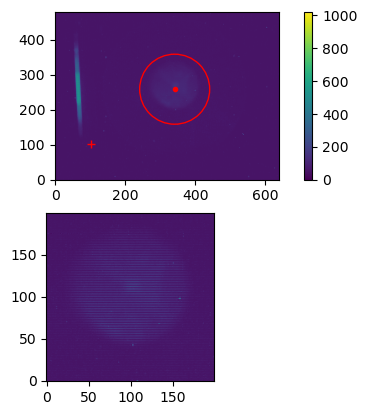

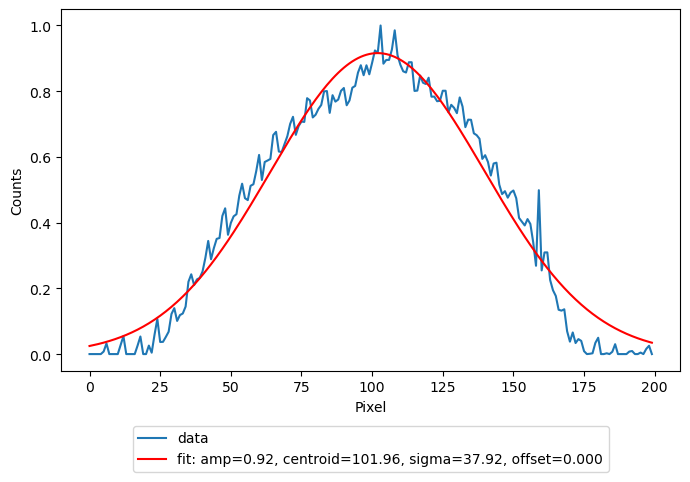

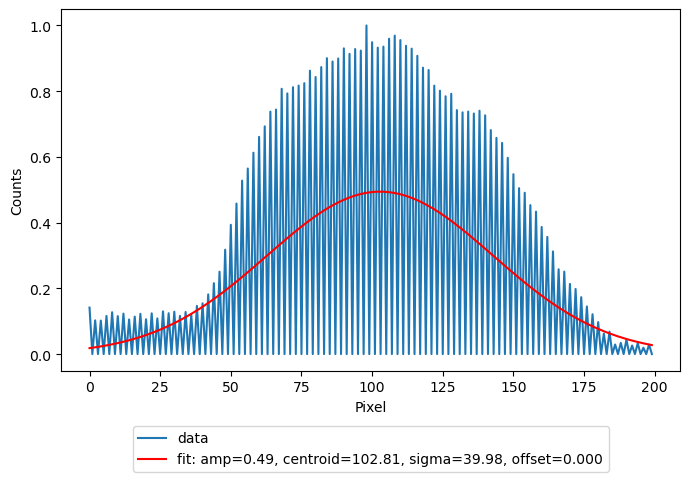

In [16]:
image_diagnostic.test_measurement()

In [17]:
evaluate({})

fitting image
103.01109644578462 100.0


{'Cx': 103.01109644578462,
 'Cy': 102.96889107225459,
 'Sx': 42.298726804952864,
 'Sy': 44.71388763957033,
 'bb_penalty': 265.5770789895921,
 'total_intensity': 3013073.0,
 'log10_total_intensity': 6.479009653781928,
 'center_dist_x': 3.0110964457846165,
 'center_dist_y': 2.9688910722545927,
 'center_dist': 4.2285950391033875,
 'time': 1708982688.2120576}

In [18]:
X.evaluate_data({name:0.0 for name in X.vocs.variable_names})


fitting image
94.01364060145417 100.0


,AWA:Drive:DT2H_A_N:Ctrl,AWA:Drive:DT2V_A_N:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
0,0.0,0.0,94.013641,103.114048,43.691011,44.988636,276.385353,3037912.0,6.482575,-5.986359,3.114048,6.747873,1.708983e+09,2.314737,False


displaying image
fitting image


{'Cx': 95.96116898467922,
 'Cy': 103.06350832640774,
 'Sx': 39.09560089320439,
 'Sy': 41.141997765550585,
 'bb_penalty': 256.9086756357826,
 'total_intensity': 2935151.0,
 'log10_total_intensity': 6.467630448609147}

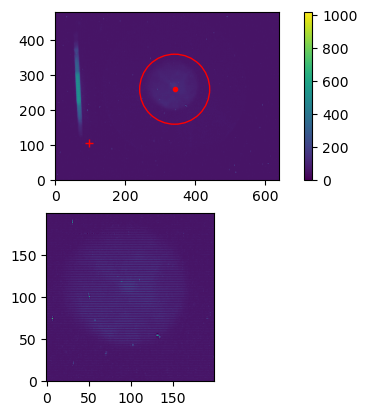

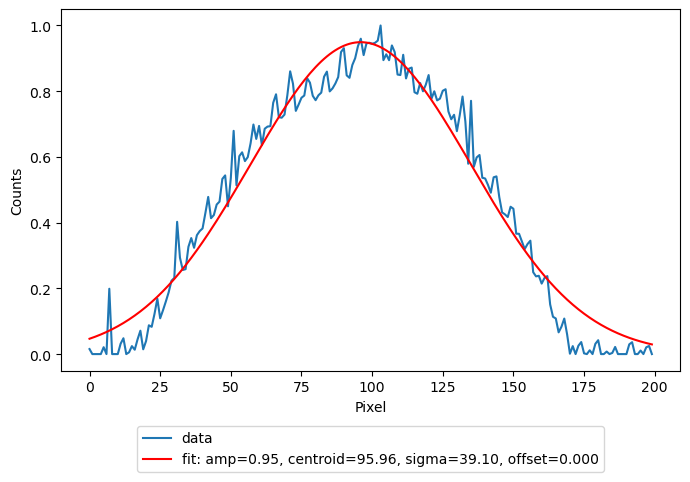

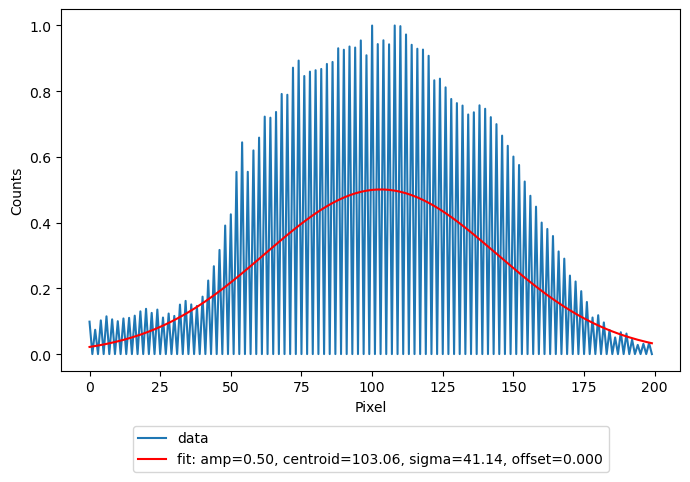

In [19]:
image_diagnostic.test_measurement()